In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

data_dir = 'F:/crs/proj/2025_NOPP_comparison/helene_water_level/DesignSafe/'
# Data is recorded at 16 Hz, but time is only precise to 1 s
fn = '2024-Sept-30_RAPID-WG01_Data.CSV' # removed first three records so it starts on even second
met_file = 'CO-OPS_8727520_met.csv' # Cedar Key

def load_high_freq_data(csv_file):
    # Load CSV file
    df = pd.read_csv(csv_file)

    # leading spaces in data are annoying...rename the columns 
    df.columns = ['date','time','pressure']
    print(df.columns)

    # # # Ensure columns exist
    # required_columns = {"date", "time", "pressure"}
    # if not required_columns.issubset(df.columns):
    #     raise KeyError(f"Missing required columns: {required_columns - set(df.columns)}")

    # Combine date and time columns into a single datetime column
    df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"], format="mixed")

    # Generate sub-second timestamps (assuming 16 samples per second)
    df["sample_index"] = df.groupby("datetime").cumcount()  # Count samples per second
    df["milliseconds"] = (df["sample_index"] * (1000 / 16)).astype(int)  # Convert to milliseconds

    # Create final datetime with microsecond precision
    df["datetime"] = df["datetime"] + pd.to_timedelta(df["milliseconds"], unit="ms")

    # Drop intermediate columns
    df = df.drop(columns=["date", "time", "sample_index", "milliseconds"])

    return df


def lowpass_and_resample(df, column='pressure', sample_rate=16, cutoff_freq=1/25, resample_interval='6min', order=4):
    """
    Apply a Butterworth low-pass filter and resample the data to a lower frequency.
    
    Parameters:
    - df: DataFrame with 'datetime' and pressure column
    - column: the name of the column to filter
    - sample_rate: original sampling rate in Hz
    - cutoff_freq: low-pass filter cutoff frequency in Hz
    - resample_interval: string like '6T' for 6-minute intervals
    - order: filter order
    
    Returns:
    - Resampled DataFrame with filtered pressure
    """
    # Design Butterworth filter
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    # Apply filter
    df['pressure_filtered'] = filtfilt(b, a, df[column])

    # Resample to specified interval
    df_resampled = (
        df.set_index('datetime')['pressure_filtered']
        .resample(resample_interval)
        .mean()
        .reset_index()
    )

    return df_resampled


def smooth_and_resample(df, window_size=9600, resample_interval="10T"):
    """
    Smooths the pressure data using a rolling mean and resamples it to 10-minute intervals.
    
    Parameters:
    - df: Pandas DataFrame with 'datetime' and 'pressure' columns.
    - window_size: Number of samples for rolling mean (default: 9600 for 10 minutes at 16 Hz).
    - resample_interval: Resampling frequency ('10T' for 10 minutes).
    
    Returns:
    - Resampled DataFrame with smoothed pressure data.
    """
    # Apply a rolling mean for smoothing
    df["smoothed_pressure"] = df["pressure"].rolling(window=window_size, min_periods=1, center=True).mean()

    # Resample to 10-minute intervals (taking mean)
    df_resampled = df.set_index("datetime").resample(resample_interval).mean().reset_index()

    return df_resampled


# load the pressure data
df = load_high_freq_data(data_dir+fn)

# Filter and resample at 6 min, anticipating the baro data will be 6 min
df_smooth_6min = lowpass_and_resample(
    df,
    column='pressure',
    sample_rate=16,
    cutoff_freq=1/25,
    resample_interval='6min'
)

df_smooth_6min

Index(['date', 'time', 'pressure'], dtype='object')


,datetime,pressure_filtered
0,2024-09-25 07:54:00,1005.701536
1,2024-09-25 08:00:00,1005.418852
2,2024-09-25 08:06:00,1004.523270
3,2024-09-25 08:12:00,1003.975216
4,2024-09-25 08:18:00,1003.523582
...,...,...
1269,2024-09-30 14:48:00,1003.487596
1270,2024-09-30 14:54:00,1003.391887
1271,2024-09-30 15:00:00,1003.327841
1272,2024-09-30 15:06:00,1003.249628


In [2]:
# Load met data to correct for barometric pressure
df_met = pd.read_csv(data_dir+met_file)

# Parse datetime from "Date" and "Time (GMT)"
df_met["datetime"] = pd.to_datetime(df_met["Date"] + " " + df_met["Time (GMT)"])
df_met

,Date,Time (GMT),Wind Speed (m/s),Wind Dir (deg),Wind Gust (m/s),Air Temp (°C),Baro (mb),Humidity (%),Visibility (km),datetime
0,2024/09/25,00:00,2.0,338,3.2,29.1,1011.3,-,-,2024-09-25 00:00:00
1,2024/09/25,00:06,1.7,340,2.7,29.1,1011.3,-,-,2024-09-25 00:06:00
2,2024/09/25,00:12,1.7,346,2.5,29.0,1011.3,-,-,2024-09-25 00:12:00
3,2024/09/25,00:18,2.0,350,2.6,28.9,1011.4,-,-,2024-09-25 00:18:00
4,2024/09/25,00:24,1.6,347,2.6,28.8,1011.4,-,-,2024-09-25 00:24:00
...,...,...,...,...,...,...,...,...,...,...
1435,2024/09/30,23:30,1.8,230,2.2,28.1,1012.4,-,-,2024-09-30 23:30:00
1436,2024/09/30,23:36,1.7,232,2.1,28.1,1012.3,-,-,2024-09-30 23:36:00
1437,2024/09/30,23:42,2.4,229,2.7,28.1,1012.4,-,-,2024-09-30 23:42:00
1438,2024/09/30,23:48,2.3,208,2.5,28.1,1012.4,-,-,2024-09-30 23:48:00


In [4]:
df_smooth_6min['datetime'] = pd.to_datetime(df_smooth_6min['datetime'])
df_met['datetime'] = pd.to_datetime(df_met['datetime'])

# Merge the pressure two dataframes on datetime
df_merged = pd.merge(df_smooth_6min, df_met[['datetime', 'Baro (mb)']], on='datetime', how='inner')

# Subtract Baro (mb) from pressure_filtered and convert to decibars
df_merged['pressure_corrected_dbar'] = (df_merged['pressure_filtered'] - df_merged['Baro (mb)'])/100.

df_merged

,datetime,pressure_filtered,Baro (mb),pressure_corrected_dbar
0,2024-09-25 07:54:00,1005.701536,1010.8,-0.050985
1,2024-09-25 08:00:00,1005.418852,1010.7,-0.052811
2,2024-09-25 08:06:00,1004.523270,1010.8,-0.062767
3,2024-09-25 08:12:00,1003.975216,1010.7,-0.067248
4,2024-09-25 08:18:00,1003.523582,1010.6,-0.070764
...,...,...,...,...
1269,2024-09-30 14:48:00,1003.487596,1014.4,-0.109124
1270,2024-09-30 14:54:00,1003.391887,1014.5,-0.111081
1271,2024-09-30 15:00:00,1003.327841,1014.5,-0.111722
1272,2024-09-30 15:06:00,1003.249628,1014.6,-0.113504


Text(0, 0.5, 'Pressure - Barometric Pressure (db)')

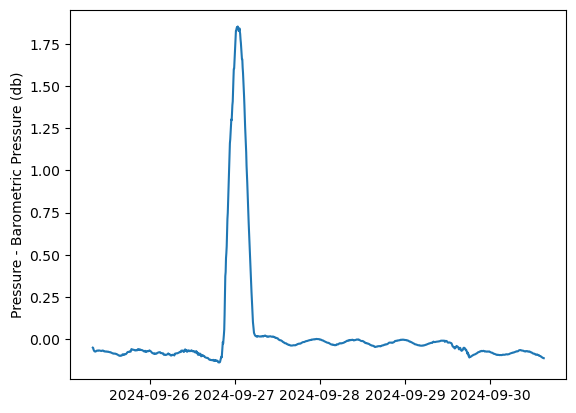

In [6]:
plt.plot( df_merged['datetime'],df_merged['pressure_corrected_dbar'])
plt.ylabel('Pressure - Barometric Pressure (db)')

F:/crs/proj/2025_NOPP_comparison/helene_water_level/DesignSafe\2024-Sept-30_RAPID-WG04_Data.CSV
Index(['date', 'time', 'pressure'], dtype='object')
WG01
Index(['date', 'time', 'pressure'], dtype='object')
WG04
Index(['date', 'time', 'pressure'], dtype='object')
WG05
Index(['date', 'time', 'pressure'], dtype='object')
WG11
Index(['date', 'time', 'pressure'], dtype='object')
WG13
Index(['date', 'time', 'pressure'], dtype='object')
WG14
Index(['date', 'time', 'pressure'], dtype='object')
WG16
Index(['date', 'time', 'pressure'], dtype='object')
WG19
Index(['date', 'time', 'pressure'], dtype='object')
WG20


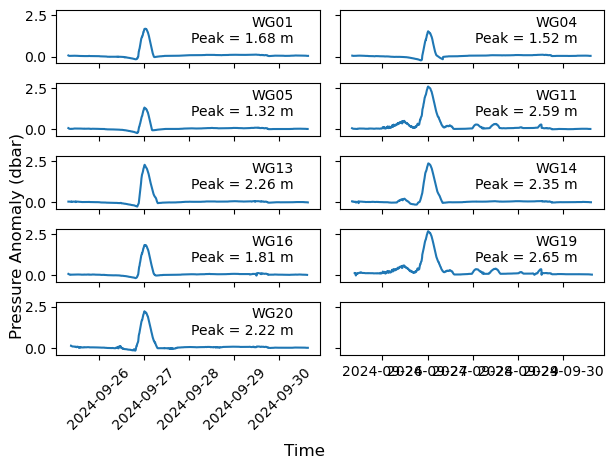

In [58]:
# find all of the .csv files in a folder
import glob
import numpy as np
flist = glob.glob( data_dir+'2024-Sept*.csv')
fn = flist[1]
print(fn)

fig, axes = plt.subplots( 5, 2, sharex=True, sharey=True)

for i, fn in enumerate(flist):
# load the pressure data
    df = load_high_freq_data( fn )
    
    # Filter and resample at 6 min, anticipating the baro data will be 6 min
    dfs = lowpass_and_resample(
        df,
        column='pressure',
        sample_rate=16,
        cutoff_freq=1/(6*60),
        resample_interval='6min'
    )
    dfs['dbar'] = ( dfs['pressure_filtered']-1000. )/100.
    sta = fn[82:86]
    peak = dfs['dbar'].max()
    tss = '{}\nPeak = {:.2f} m'.format(sta, peak)
    print(sta)
    
    ax = axes.flatten()
    ax[i].plot( dfs['datetime'], dfs['dbar'] )
    ax[i].text(.9, .9, tss, fontsize=10,  horizontalalignment='right',
        verticalalignment='top',transform=ax[i].transAxes )
    # Rotate y-axis tick labels
    ax[i].tick_params(axis='x', labelrotation=45)

# Common y-label in the middle of left column
fig.text(0.04, 0.5, 'Pressure Anomaly (dbar)', va='center', rotation='vertical', fontsize=12)

# Optional: common x-label too
fig.text(0.5, 0.04, 'Time', ha='center', fontsize=12)
plt.tight_layout(rect=[0.06, 0.06, 1, 1])  # leave space for labels
plt.savefig( data_dir + 'rapid_station.png', dpi=200, bbox_inches = 'tight' )


                            datetime  pressure_filtered         dbar
count                           1267        1267.000000  1267.000000
mean   2024-09-27 23:17:59.999999744        1008.142066     0.081421
min              2024-09-25 08:00:00         976.673454    -0.233265
25%              2024-09-26 15:39:00        1001.635893     0.016359
50%              2024-09-27 23:18:00        1004.442020     0.044420
75%              2024-09-29 06:57:00        1007.831307     0.078313
max              2024-09-30 14:36:00        1152.440223     1.524402
std                              NaN          24.002586     0.240026


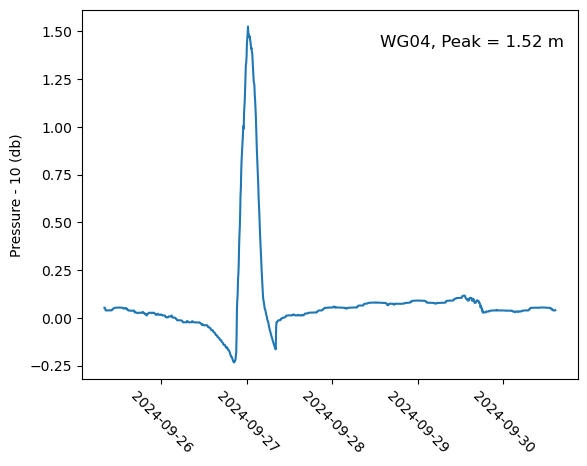

In [47]:
sta = fn[82:86]
peak = dfs['dbar'].max()
tss = '{}, Peak = {:.2f} m'.format(sta, peak)
print( dfs.describe() )

fig, ax = plt.subplots( 1, 1)
plt.plot( dfs['datetime'], dfs['dbar'] )
ax.text(.6, .9, tss, fontsize=12, transform=ax.transAxes )
plt.ylabel('Pressure - 10 (db)')
plt.xticks(rotation=-45)
plt.savefig( data_dir + sta + '.png', dpi=200, bbox_inches = 'tight' )